In [38]:

matplotlib.rc("image",cmap="gray")
from scipy.ndimage import filters,interpolation,measurements
from scipy.spatial.distance import cdist
AND=logical_and; OR=logical_or; NOT=logical_not
figsize(12,6)

# Sample Images

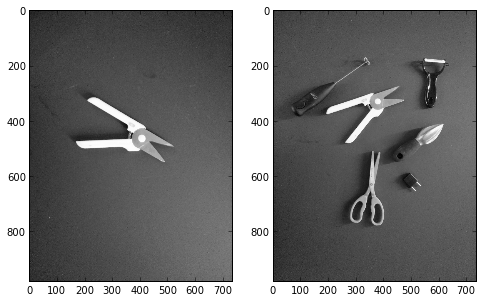

In [97]:
target = interpolation.zoom(mean(imread("match-target.png"),axis=2),0.3)
subplot(121); imshow(target)
clutter = interpolation.zoom(mean(imread("match-clutter.png"),axis=2),0.3)
subplot(122); imshow(clutter)

# Interest Point Detection for Matching

In [98]:
def harris(image,sigma=1.0,area=5.0):
    dx = filters.gaussian_filter(image,sigma,(0,1))
    dy = filters.gaussian_filter(image,sigma,(1,0))
    sxx = filters.gaussian_filter(dx**2,area)
    sxy = filters.gaussian_filter(dx*dy,area)
    syy = filters.gaussian_filter(dy**2,area)
    T = sxx+syy
    D = sxx*syy-sxy**2
    R = (T**2-4*D)**.5
    hi = (T+R)/2
    lo = (T-R)/2
    return lo

In [99]:
def harrisloc(image,sigma=1.0,area=5.0,hi=0.05,lo=1.0,r=20):
    h = harris(image,sigma=sigma,area=area)
    threshold = max(hi*amax(h),lo*var(h)**.5+mean(h))
    c = AND(h==filters.maximum_filter(h,20),h>threshold)
    l,n = measurements.label(c)
    p = measurements.center_of_mass(c,l,range(1,n))
    return array(p)

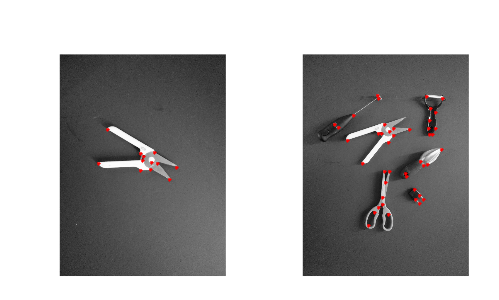

In [100]:
tp = harrisloc(target)
cp = harrisloc(clutter)
subplot(121); axis("off"); imshow(target); plot(tp[:,1],tp[:,0],'r.')
subplot(122); axis("off"); imshow(clutter); plot(cp[:,1],cp[:,0],'r.')

# 2D Points as Complex Numbers

In [102]:
def complex2points(c):
    return c_[real(c),imag(c)]
def points2complex(p):
    return p[:,0]+1j*p[:,1]

In [103]:
def ppoints(p,*args,**kw):
    if type(p)==complex:
        plot([real(p)],[imag(p)],*args,**kw)
    elif p.ndim==1:
        ps = complex2points(p)
        plot(ps[:,0],ps[:,1],*args,**kw)
    elif p.ndim==2:
        plot(p[:,0],p[:,1],*args,**kw)
    else:
        raise Exception("unknown type")

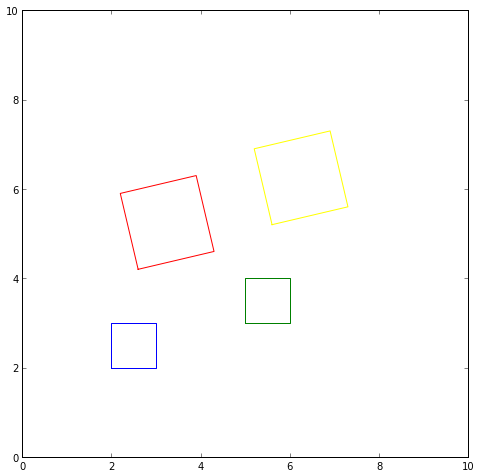

In [108]:
figsize(8,8); xlim((0,10)); ylim((0,10))
M = array([2+2j,3+2j,3+3j,2+3j,2+2j],complex)
translation = 3+1j
rotation = 1.7+0.4j
ppoints(M,color='blue')
ppoints(M+translation,color='green')
ppoints(rotation*points,color='red')
ppoints(rotation*points+translation,color='yellow')

In [110]:
B = rotation*M+translation
est_rotation = (B[1]-B[0])/(M[1]-M[0])
print rotation,est_rotation
est_translation = B[0]-rotation*M[0]
print translation,est_translation

(1.7+0.4j) (1.7+0.4j)
(3+1j) (3+1j)


In [121]:
def evaluate(M,B,translation,rotation,eps=5.0):
    P = rotation*M+translation
    dists = cdist(complex2points(P),complex2points(B))
    min_dists = amin(dists,axis=1)
    return sum(min_dists<eps)

In [123]:
print evaluate(M,M,0,1,eps=1)
print evaluate(M,rotation*M+translation,0,1,eps=1)
print evaluate(M,rotation*M+translation,translation,rotation,eps=1)

5
0
5


# Recognition by Alignment / RANSAC

In [130]:
M = points2complex(tp)
B = points2complex(cp)

In [144]:
best_q = -1
best = None
neval = 0
for i in range(len(M)):
    for j in range(len(M)):
        m1 = M[i]
        m2 = M[j]
        if abs(m1-m2)<10: continue
        for k in range(len(B)):
            for l in range(len(B)):
                b1 = B[k]
                b2 = B[l]
                if abs(b1-b2)<10: continue
                rotscale = (b2-b1)/(m2-m1)
                translation = b1-rotscale*m1
                if abs(rotscale)<0.5 or abs(rotscale)>2.0: continue
                q = evaluate(M,B,translation,rotscale,eps=20)
                neval += 1
                if q>best_q:
                    best_q = q
                    best = (translation,rotscale)
                    print best_q,best
print neval

5 ((-17.362458453044894+18.323812742944085j), (0.85116331474283136+0.40009013576699903j))
6 ((-90.387978142076463-74.065573770491824j), (1.1366120218579234+0.49726775956284153j))
9 ((-93.540025914033038+355.78220945298858j), (0.54594107374232437-0.43146864965354065j))
10 ((30.004732127767454+11.147259309334686j), (0.79916624415525883+0.12326066137119035j))
11 ((337.32764351304149-108.64531575685874j), (0.50735169849585937+0.5978254746211481j))
100840


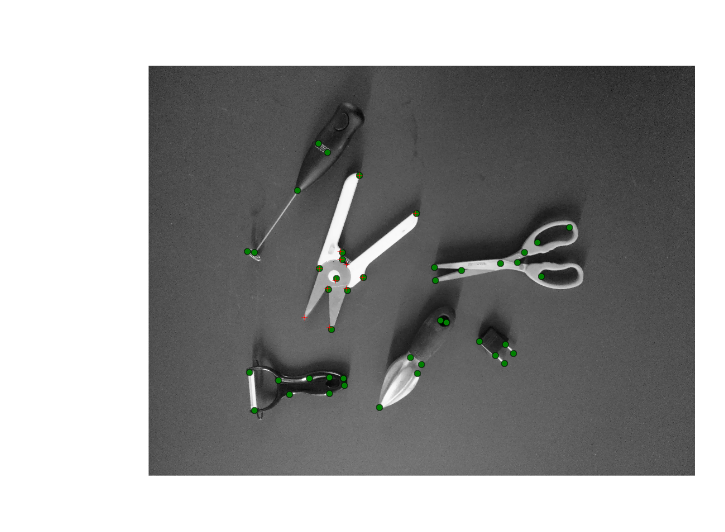

In [145]:
figsize(12,12)
axis("off"); imshow(clutter.T)
ppoints(B,'go')
translation,rotation = best
ppoints(rotation*M+translation,'r+')